In [1]:
    #     # Distribuciones gaussianas
    # 'gauss_5_1': {'type': 'gaussian', 'params': {'mu': 5.0, 'sigma': 1.0}},
    # 'gauss_10_2': {'type': 'gaussian', 'params': {'mu': 10.0, 'sigma': 2.0}},
    # 'gauss_20_5': {'type': 'gaussian', 'params': {'mu': 20.0, 'sigma': 5.0}},
    # 'gauss_30_3': {'type': 'gaussian', 'params': {'mu': 30.0, 'sigma': 3.0}},
    
    # # Distribuciones beta (sesgadas hacia delays cortos)
    # 'beta_short': {'type': 'beta', 'params': {'alpha': 2, 'beta': 8, 'scale': 20}},  # Sesgada a delays cortos
    # 'beta_long': {'type': 'beta', 'params': {'alpha': 8, 'beta': 2, 'scale': 30}},   # Sesgada a delays largos
    # 'beta_uniform': {'type': 'beta', 'params': {'alpha': 5, 'beta': 5, 'scale': 25}}, # Casi uniforme
    
    # # Distribuciones uniformes
    # 'uniform_0_10': {'type': 'uniform', 'params': {'low': 0.5, 'high': 10.0}},
    # 'uniform_10_30': {'type': 'uniform', 'params': {'low': 10.0, 'high': 30.0}},
    # 'uniform_20_50': {'type': 'uniform', 'params': {'low': 20.0, 'high': 50.0}},

In [2]:
import os

os.chdir("../../")

from src.two_populations.model import IzhikevichNetwork
from src.two_populations.sweep import delay_distribution_sweep, save_results, plot_delay_comparison, save_results_with_csv
from src.two_populations.metrics import analyze_simulation_results, plot_connectivity_dashboard, plot_population_dashboard
from brian2 import *
from brian2cuda import *


os.environ['CXXFLAGS'] = '-fopenmp'
os.environ['LDFLAGS'] = '-lgomp'

restore_initial_state()

device_mode = 'runtime'

# Configurar device ANTES de crear objetos
if device_mode == 'cpp_standalone':
    set_device('cpp_standalone', directory='output', build_on_run=True)
    prefs.devices.cpp_standalone.openmp_threads = 20
elif device_mode == 'cuda_standalone':
    set_device('cuda_standalone', directory='output', build_on_run=False)
# Si es 'runtime', usar device por defecto

/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(


In [3]:
k_factor = 4
noise_int = 5.1 # 5.1 

noise_inh_factor = 0.451
inter_k_factor = 0.5

# Definir parámetros base
base_params = {
    'pop_A': {
        'Ne': 800, 'Ni': 200, 
        'k_exc': k_factor*0.5, 'k_inh': k_factor*1.0,
        'noise_exc': noise_int, 'noise_inh': round(noise_int * noise_inh_factor, 2), 
        'p_intra': 0.1, 'delay': 0.0, 
        'noise_type': 'poisson'
    },
    'pop_B': {
        'Ne': 800, 'Ni': 200,
        'k_exc': k_factor*0.5, 'k_inh': k_factor*1.0, 
        'noise_exc': noise_int, 'noise_inh': round(noise_int * noise_inh_factor, 2),
        'p_intra': 0.1, 'delay': 0.0,
        'noise_type': 'poisson'
    },
    'connection': {
        'p_inter': 0.01,
        'weight_scale': k_factor*inter_k_factor
    }
}

WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/metrics.py:578: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/metrics.py:679: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]


nperseg=2249, noverlap=562, len(signal_A)=17999

=== Análisis de Conectividad - AtoB_delta4ms ===
Cross-correlation peak: 0.094 at 7.5ms
PLV Alpha: 0.127
PLI Alpha: 0.050
PLV Gamma: 0.119
PLI Gamma: 0.119
Coherence peak: 0.380 at 37.3Hz
Intrinsic timescales: Pop A = 3.0ms (poor), Pop B = 3.3ms (poor)


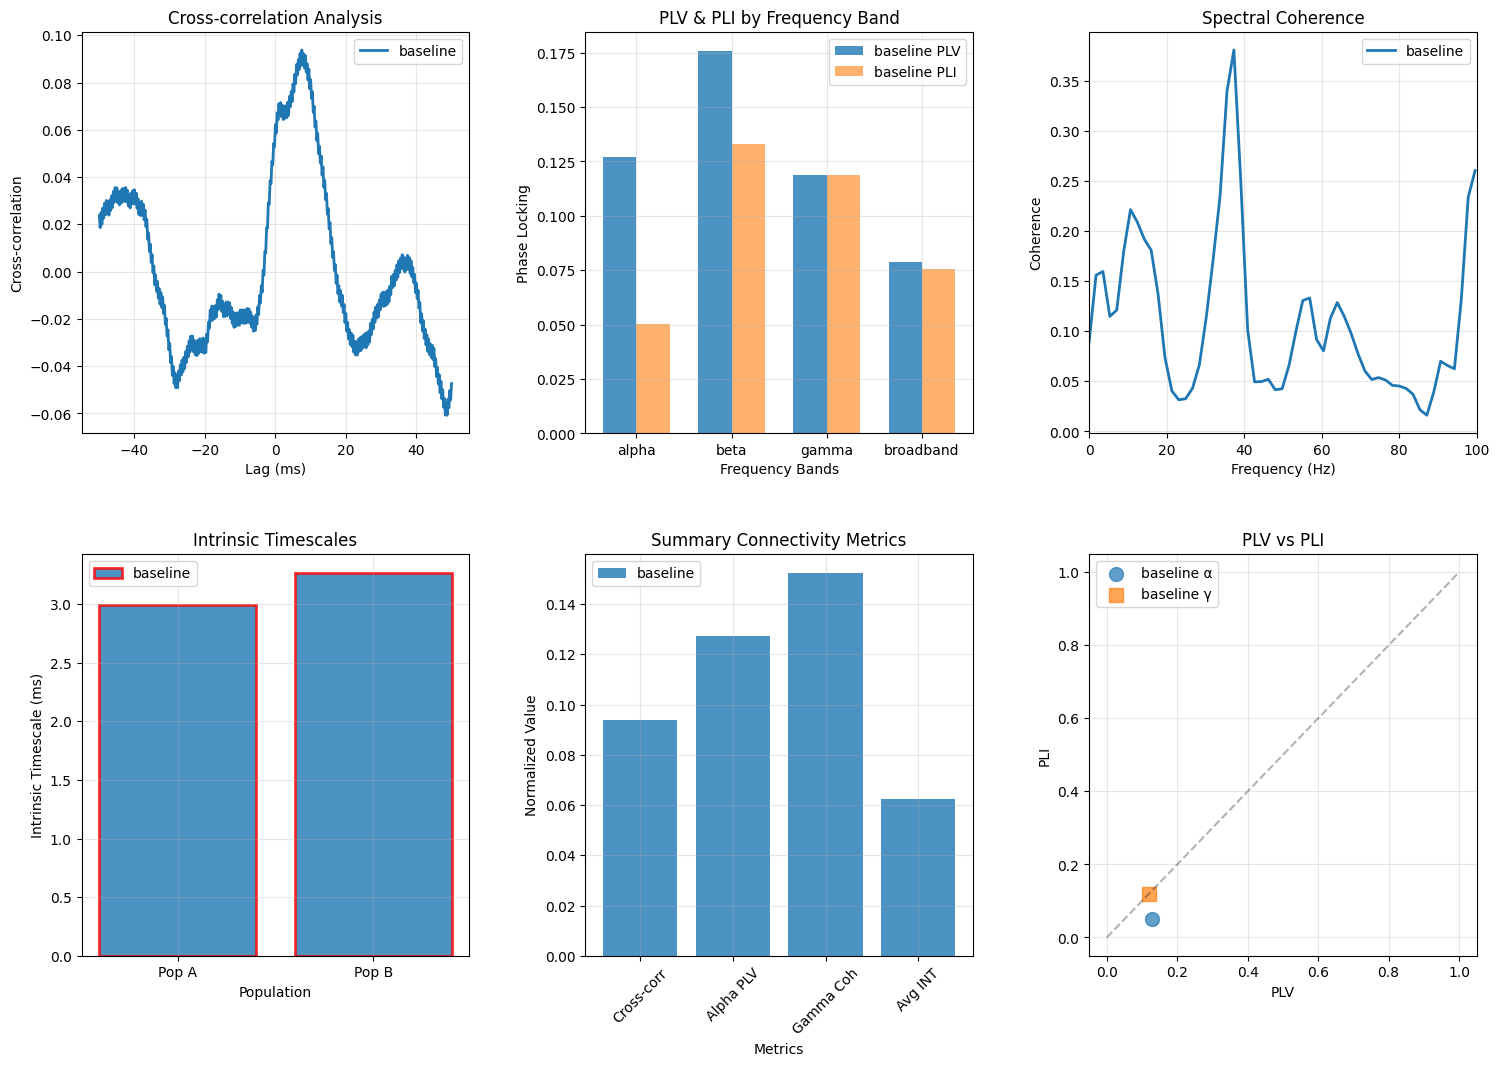

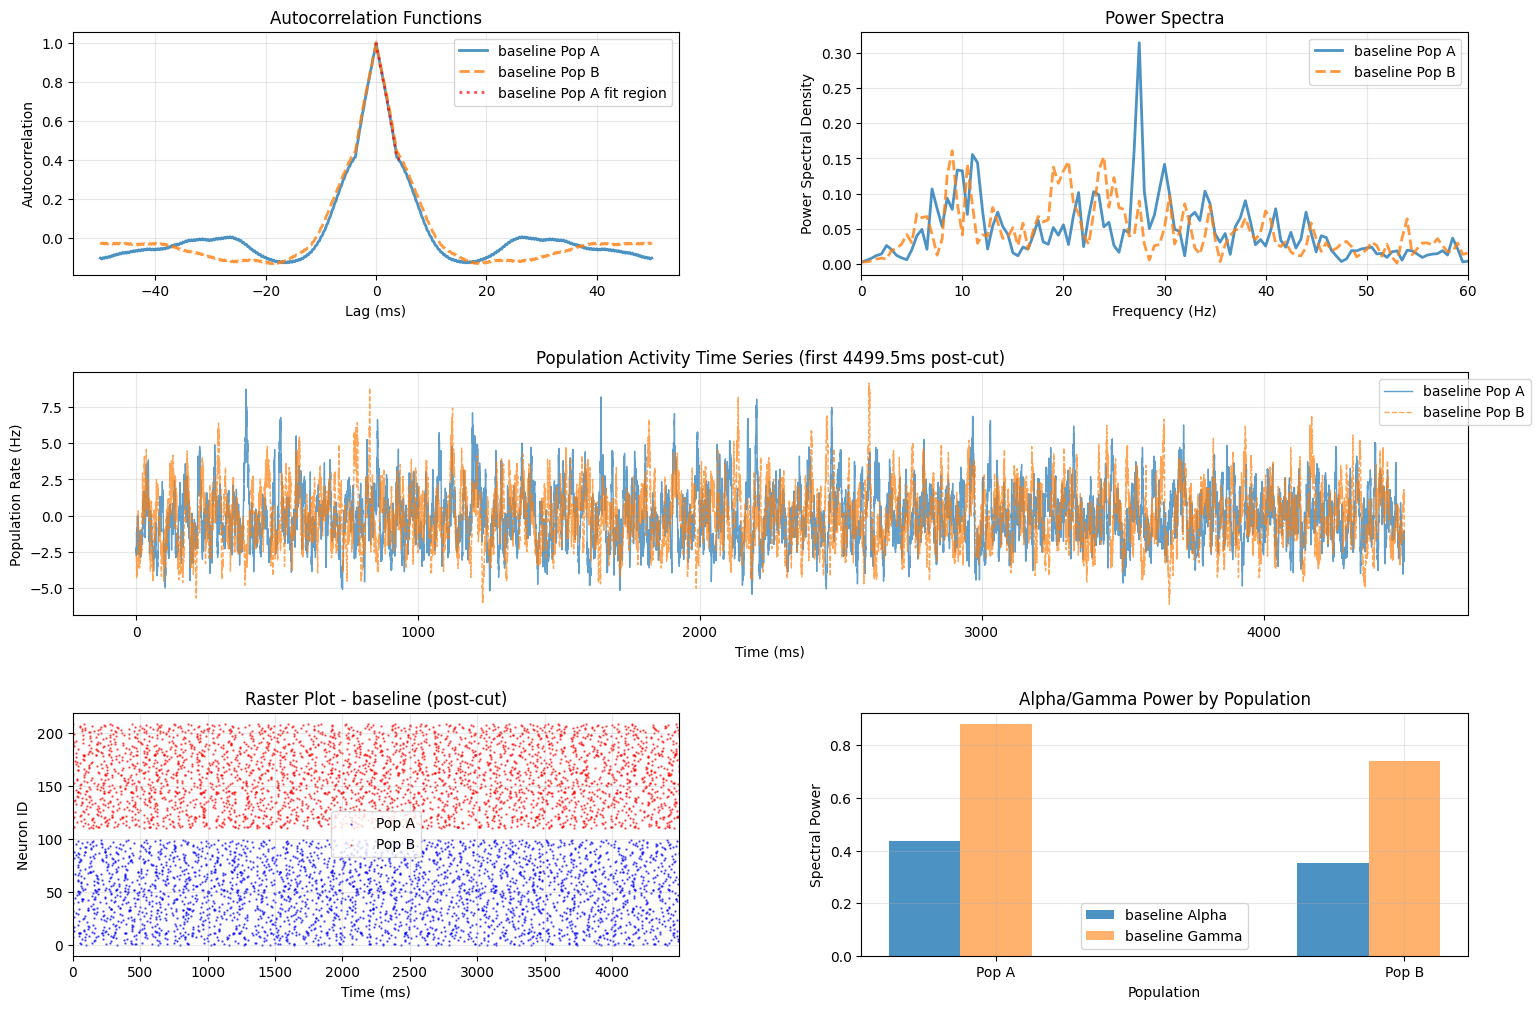

In [4]:
cfg = dict(dt=0.1, T_total=5000, warmup=500, delay_ms=4.0, seed=42)

start_scope()
sim = IzhikevichNetwork(dt_val=cfg['dt'], T_total=cfg['T_total'], fixed_seed=cfg['seed'], variable_seed=cfg['seed'])

# Poblaciones simétricas (tus base_params)
sim.create_population('A', **base_params['pop_A'])
sim.create_population('B', **base_params['pop_B'])

# Conexión unidireccional A->B con delay delta
sim.connect_populations('A','B',
    p_inter=base_params['connection']['p_inter'],
    weight_scale=base_params['connection']['weight_scale'],
    delay_value=cfg['delay_ms'])

# sim.connect_populations('B','A',
#     p_inter=base_params['connection']['p_inter'],
#     weight_scale=base_params['connection']['weight_scale'],
#     delay_value=cfg['delay_ms'])

sim.setup_monitors(['A','B'])
results = sim.run_simulation()  # si runtime; si standalone haz luego sim.get_results()


res = {'baseline': analyze_simulation_results(
    results['A']['spike_monitor'], results['B']['spike_monitor'],
    N=base_params['pop_A']['Ne']+base_params['pop_A']['Ni'],
    condition_name=f"AtoB_delta{int(cfg['delay_ms'])}ms")}
fig1 = plot_connectivity_dashboard(res)
fig2 = plot_population_dashboard(res)


In [19]:
k_factor = 4
noise_int = 5.1 # 5.1 

noise_inh_factor = 0.451
inter_k_factor = 0.5

# Definir parámetros base
base_params = {
    'pop_A': {
        'Ne': 800, 'Ni': 200, 
        'k_exc': k_factor*0.5, 'k_inh': k_factor*1.0,
        'noise_exc': noise_int, 'noise_inh': round(noise_int * noise_inh_factor, 2), 
        'p_intra': 0.1, 'delay': 1.0, 
        'noise_type': 'poisson'
    },
    'pop_B': {
        'Ne': 800, 'Ni': 200,
        'k_exc': k_factor*0.5, 'k_inh': k_factor*1.0, 
        'noise_exc': noise_int, 'noise_inh': round(noise_int * noise_inh_factor, 2),
        'p_intra': 0.1, 'delay': 1.0,
        'noise_type': 'poisson'
    },
    'connection': {
        'p_inter': 0.01,
        'weight_scale': k_factor*inter_k_factor
    }
}


delay_configs = {
    # Delays fijos (distribución delta)
    'baseline_delta_0ms': {'type': 'constant', 'value': 0.0},
    'baseline_delta_2ms': {'type': 'constant', 'value': 2.0},
    'baseline_delta_4ms': {'type': 'constant', 'value': 4.0},
    'baseline_delta_6ms': {'type': 'constant', 'value': 6.0},
    'baseline_delta_8ms': {'type': 'constant', 'value': 8.0},
    'baseline_delta_12ms': {'type': 'constant', 'value': 12.0},
}

# Ejecutar barrido
results_db = delay_distribution_sweep(0.1, 3500, IzhikevichNetwork, base_params, delay_configs, directionality=0, n_trials=5, device_mode=device_mode)

paths = save_results_with_csv(results_db, out_dir="./results/experiments/two_populations",
                            tag="delta_only", per_trial_csv=True)

# Guardar resultados
filename = save_results(results_db)

# Visualizar comparación
fig = plot_delay_comparison(results_db)

TypeError: delay_distribution_sweep() missing 1 required positional argument: 'delay_configs'

WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/metrics.py:578: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/metrics.py:679: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]


nperseg=350, noverlap=87, len(signal_A)=2800

=== Análisis de Conectividad - Baseline ===
Cross-correlation peak: 0.795 at 13.0ms
PLV Alpha: 0.912
PLI Alpha: 0.597
PLV Gamma: 0.698
PLI Gamma: 0.159
Coherence peak: 0.619 at 22.9Hz
Intrinsic timescales: Pop A = 4.8ms (poor), Pop B = 5.4ms (poor)


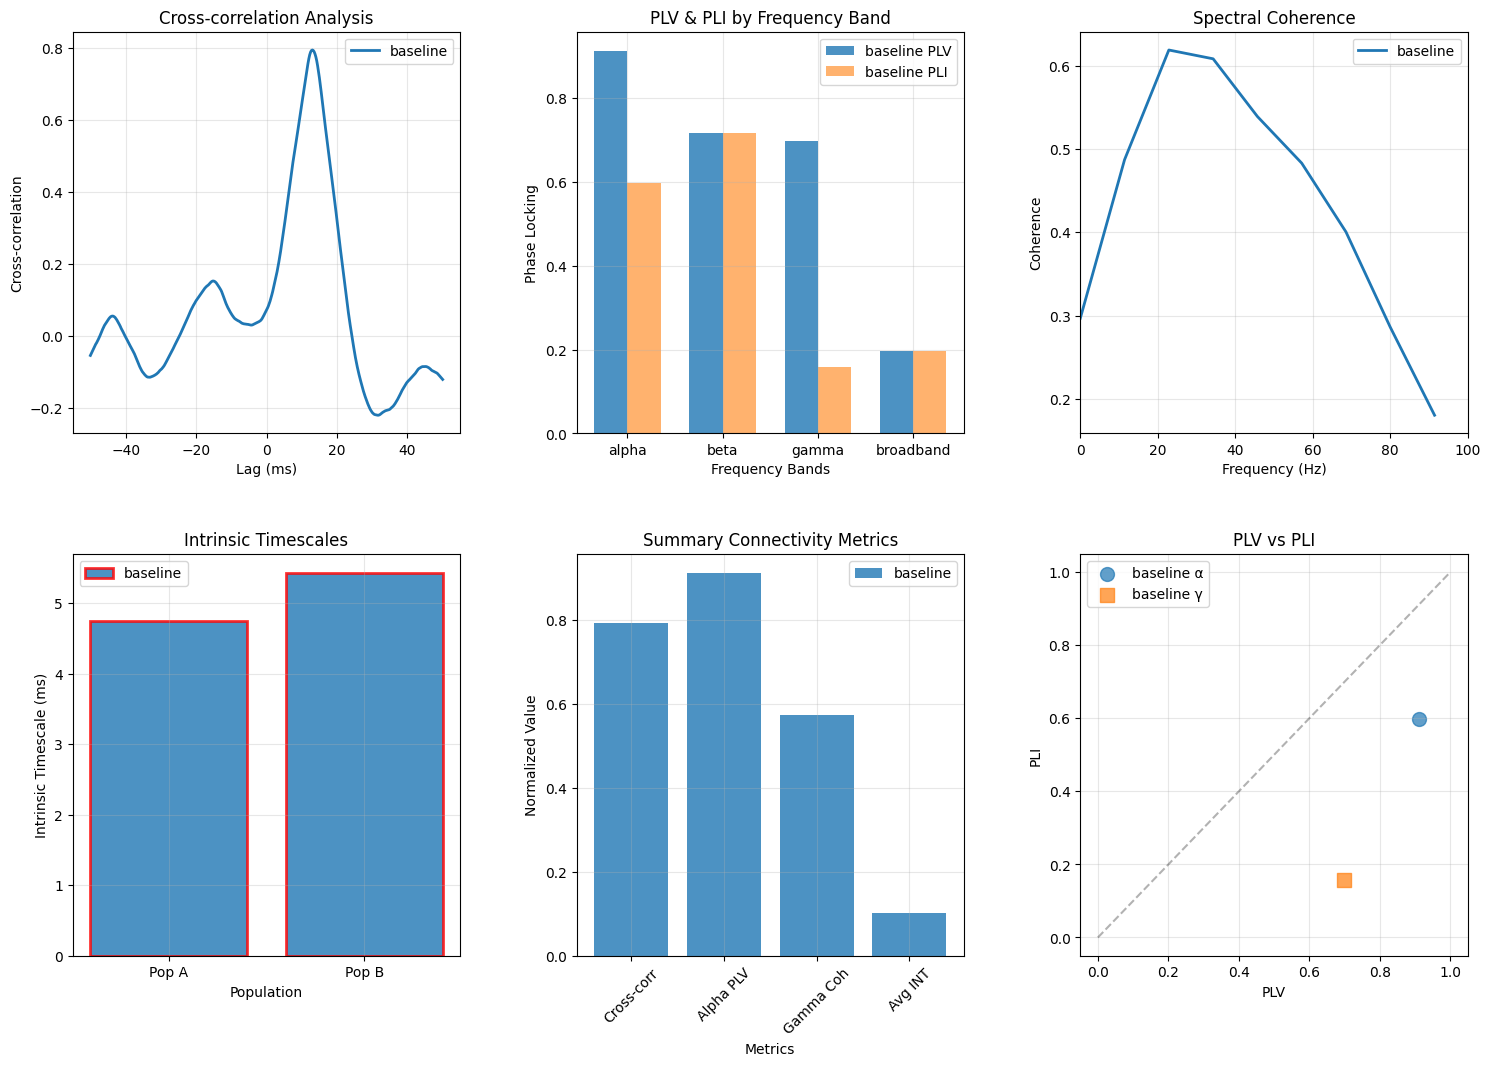

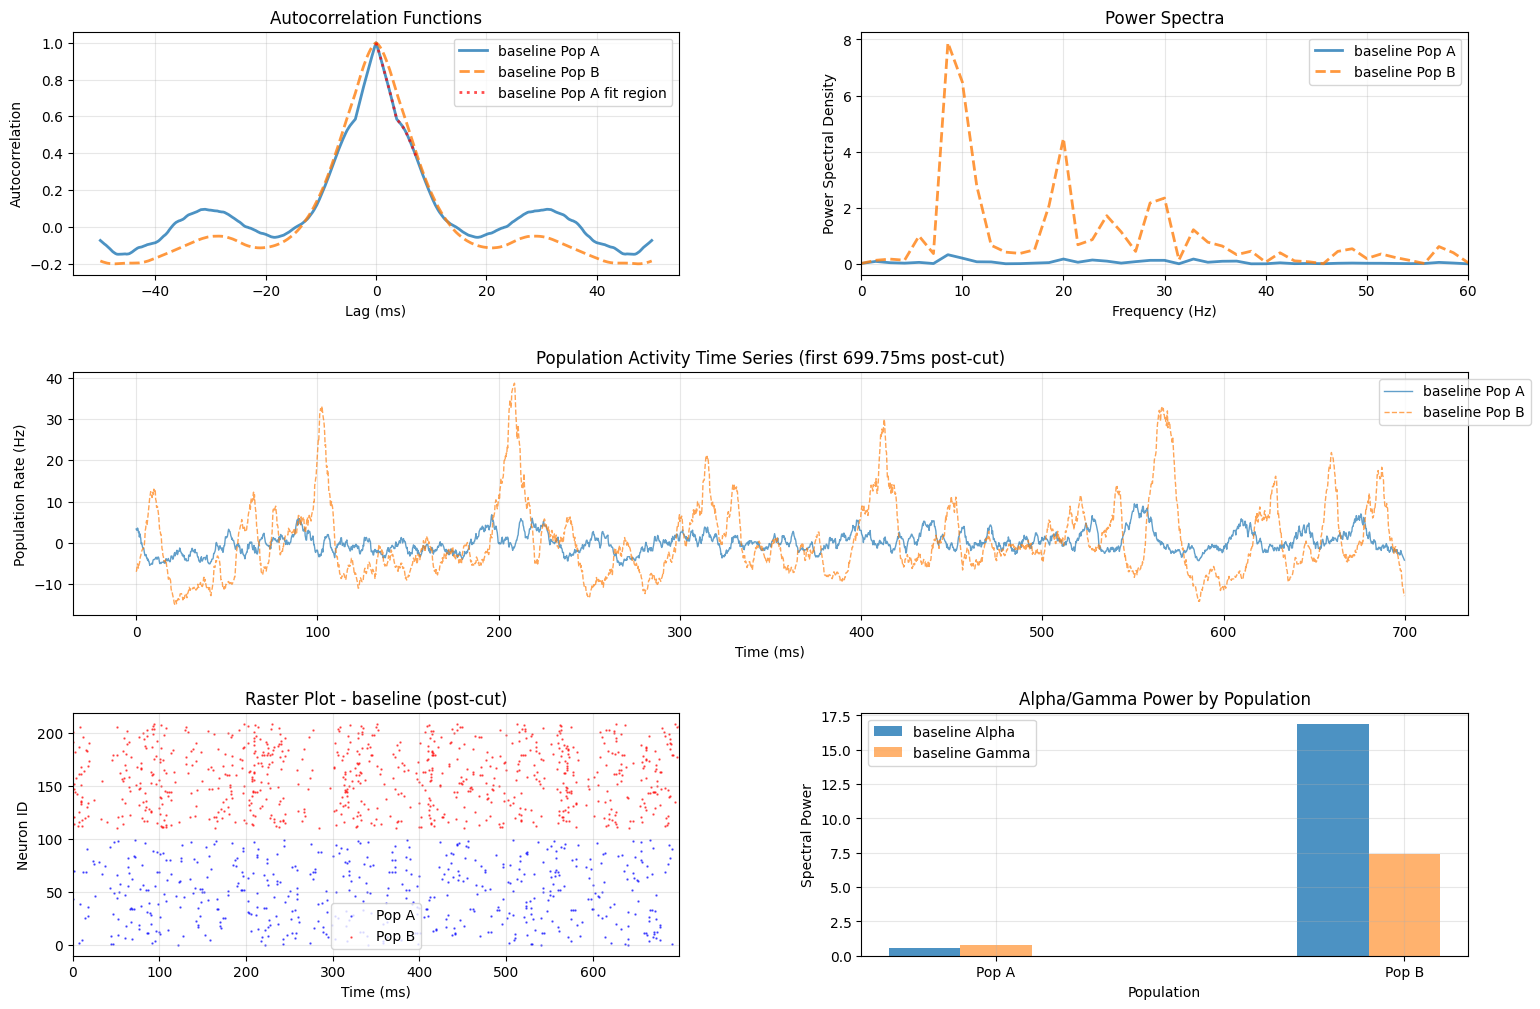

In [30]:
from src.two_populations.metrics import plot_connectivity_dashboard, analyze_simulation_results, plot_population_dashboard

start_scope()

k_factor = 5
noise_int = 5.1 # 5.1 

noise_inh_factor = 0.451
inter_k_factor = 4.0

# Crear simulador
sim = IzhikevichNetwork(dt_val=0.01, T_total=1200, fixed_seed=42, variable_seed=43)

# === POBLACIÓN A: MAESTRO (más excitable) ===
pop_A = sim.create_population('A', Ne=800, Ni=200, k_exc=k_factor*0.5, k_inh=k_factor*1.0,
                                noise_exc=noise_int, noise_inh=round(noise_int * noise_inh_factor, 2), p_intra=0.1, delay = 0.2,  noise_type='poisson')

# === POBLACIÓN B: ESCLAVO (menos excitable) ===
pop_B = sim.create_population('B', Ne=800, Ni=200, k_exc=k_factor*0.5, k_inh=k_factor*1.0,
                                noise_exc=noise_int/2, noise_inh=round(noise_int * noise_inh_factor/2, 2), p_intra=0.1, delay = 0.2, noise_type='poisson')

# === CONEXIONES ASIMÉTRICAS ===
# A→B: FUERTE y con delay específico
syn_AB = sim.connect_populations('A', 'B', p_inter=0.02,  # Más conexiones
                                weight_scale=k_factor*inter_k_factor,  # Fuerte
                                delay_value=10.0)  # Delay específico

# # # B→A: DÉBIL y con delay diferente
# syn_BA = sim.connect_populations('B', 'A', p_inter=0.005,  # Menos conexiones  
#                                 weight_scale=k_factor*inter_k_factor,  # Débil
#                                 delay_value=10.0)   # Delay corto


# Configurar monitores
sim.setup_monitors(['A', 'B'])
results = sim.run_simulation()

results_dict = {}

# Una línea para analizar
results_dict = {
    'baseline': analyze_simulation_results(results['A']['spike_monitor'], results['B']['spike_monitor'], 1000, "Baseline", warmup = 500)
}

# Dashboard
fig1 = plot_connectivity_dashboard(results_dict)  # Principal
fig2 = plot_population_dashboard(results_dict)    # Detallado

In [31]:
from src.two_populations.metrics import print_network_statistics_table

print_network_statistics_table(results, sim, 800, 200, 1200, 200)

    DEBUG: CV_individual=0.340, CV_population=1.675
    DEBUG: CV_individual=0.362, CV_population=1.932

COMPARACIÓN ESTADÍSTICAS DE RED (Post-warmup 200ms)
Métrica                   Población A               Población B              
---------------------------------------------------------------------------
ARQUITECTURA             
  Conexiones              99898                     99898
  Prob. conexión          0.1000                      0.1000
  Sparsity                0.900                       0.900

ACTIVIDAD                
  Freq exc (Hz)           7.79                        12.28
  Freq inh (Hz)           8.86                        31.60
  Ratio E/I               0.88                        0.39
  Activas exc (%)         100.0                         100.0
  Activas inh (%)         93.0                         100.0

SINCRONÍA                
  CV                      0.340                       0.362
  Fano Factor             6.122                       12.704
  Nivel

{'A': {'connections': 99898,
  'conn_prob': 0.099997997997998,
  'sparsity': 0.900002002002002,
  'freq_exc': np.float64(7.795),
  'freq_inh': np.float64(8.855),
  'ratio_ei': np.float64(0.8802936194240542),
  'active_exc_pct': np.float64(100.0),
  'active_inh_pct': np.float64(93.0),
  'cv': np.float64(0.3397082915242169),
  'fano': np.float64(6.1215950744559),
  'sync_level': 'Alta',
  'exc_weight_mean': np.float64(1.1774808262702132),
  'exc_weight_std': np.float64(0.35593095179881407),
  'inh_weight_mean': np.float64(0.6401038642722309),
  'inh_weight_std': np.float64(0.355930951798814)},
 'B': {'connections': 99898,
  'conn_prob': 0.099997997997998,
  'sparsity': 0.900002002002002,
  'freq_exc': np.float64(12.2775),
  'freq_inh': np.float64(31.6),
  'ratio_ei': np.float64(0.3885284810126582),
  'active_exc_pct': np.float64(100.0),
  'active_inh_pct': np.float64(100.0),
  'cv': np.float64(0.36237515574246226),
  'fano': np.float64(12.703777614571091),
  'sync_level': 'Alta',
  'exc_

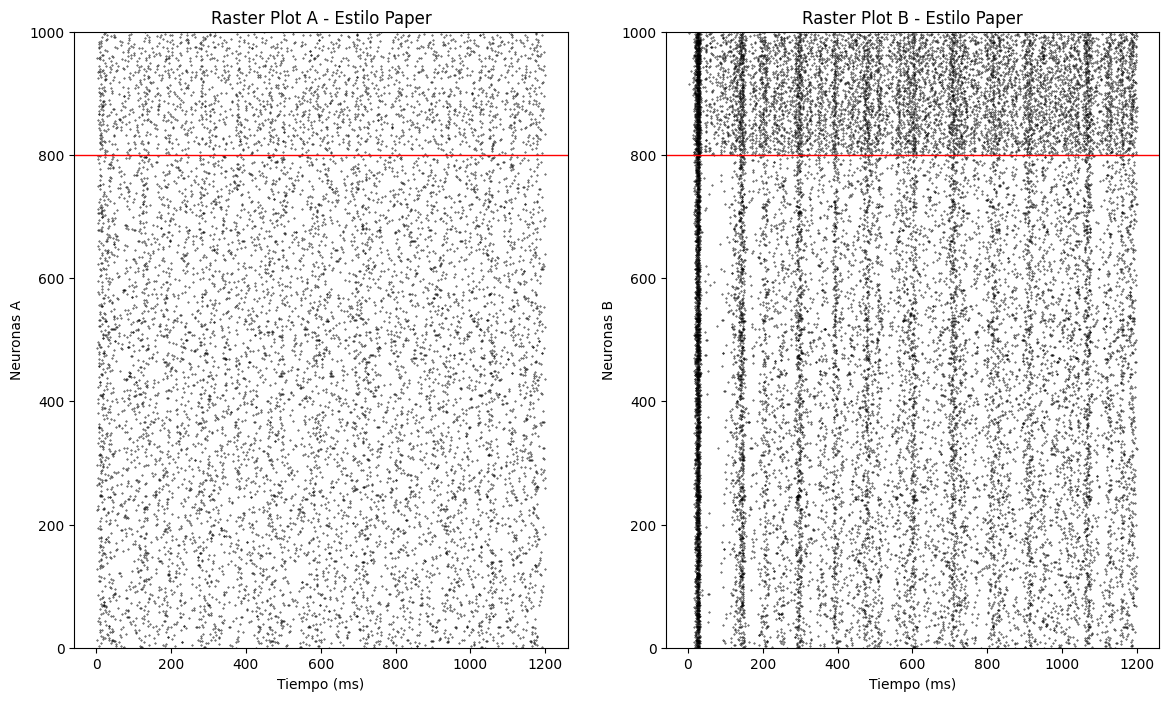

In [32]:
def plot_raster_results(results, N_exc=800, N_total=1000):
   """Graficar raster plots usando resultados de la clase"""
   figure(figsize=(14, 8))

   # Grupo A
   subplot(1, 2, 1)
   spike_mon_A = results['A']['spike_monitor']
   
   # Separar exc/inh por índices
   exc_mask_A = spike_mon_A.i < N_exc
   inh_mask_A = spike_mon_A.i >= N_exc
   
   plot(spike_mon_A.t[exc_mask_A]/ms, spike_mon_A.i[exc_mask_A], '.k', markersize=0.7)
   plot(spike_mon_A.t[inh_mask_A]/ms, spike_mon_A.i[inh_mask_A], '.k', markersize=0.7)
   axhline(y=N_exc, color='r', linestyle='-', linewidth=1)
   xlabel('Tiempo (ms)')
   ylabel('Neuronas A')
   title('Raster Plot A - Estilo Paper')
   ylim(0, N_total)

   # Grupo B
   subplot(1, 2, 2)
   spike_mon_B = results['B']['spike_monitor']
   
   exc_mask_B = spike_mon_B.i < N_exc
   inh_mask_B = spike_mon_B.i >= N_exc
   
   plot(spike_mon_B.t[exc_mask_B]/ms, spike_mon_B.i[exc_mask_B], '.k', markersize=0.7)
   plot(spike_mon_B.t[inh_mask_B]/ms, spike_mon_B.i[inh_mask_B], '.k', markersize=0.7)
   axhline(y=N_exc, color='r', linestyle='-', linewidth=1)
   xlabel('Tiempo (ms)')
   ylabel('Neuronas B')
   title('Raster Plot B - Estilo Paper')
   ylim(0, N_total)
   
   show()
   
plot_raster_results(results)

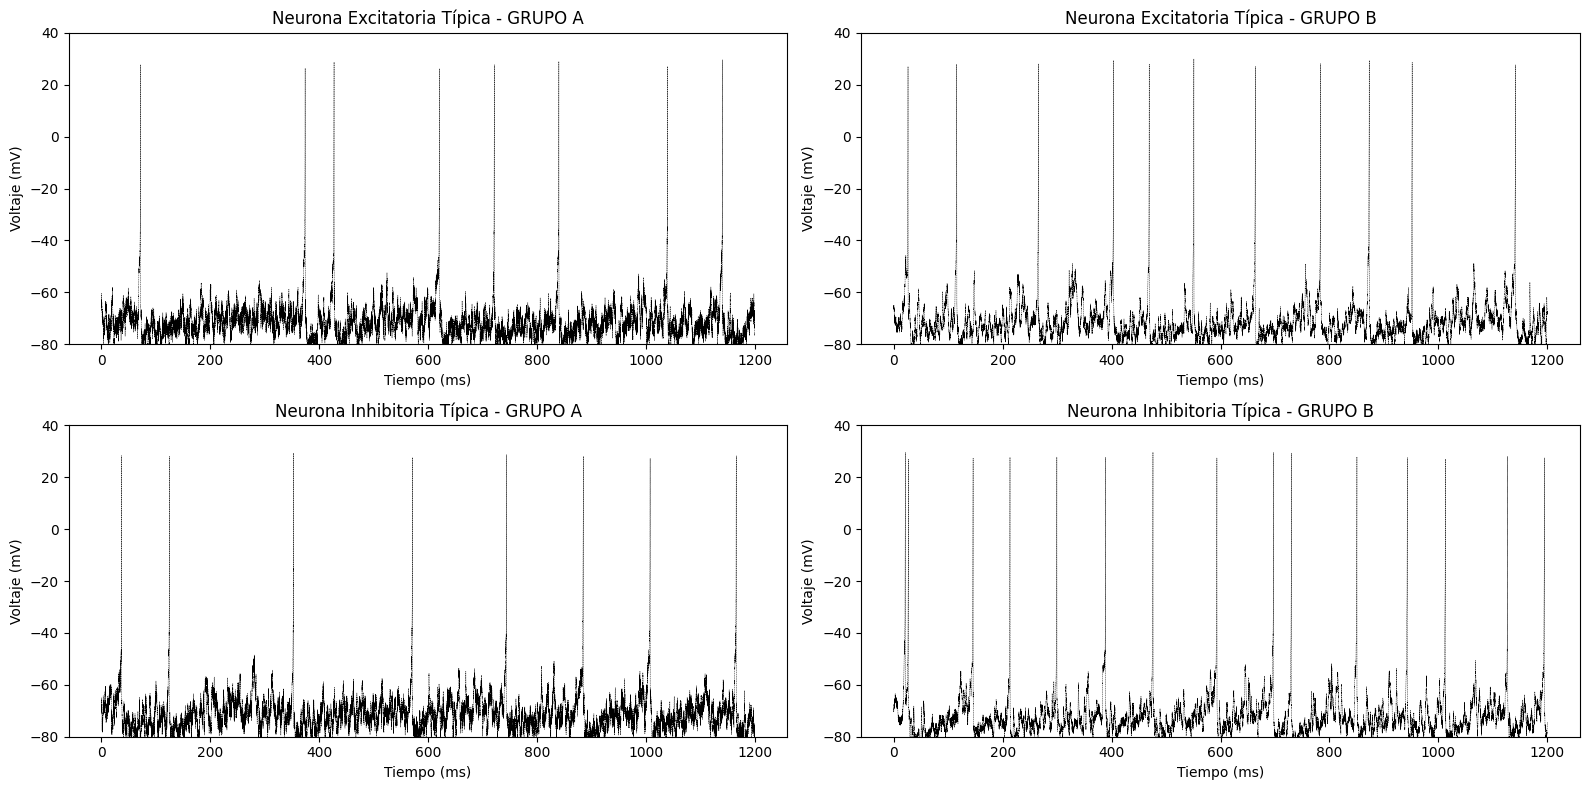

In [33]:
def plot_voltage_traces(results, N_exc=800, neuron_idx=0):
    """Graficar trazas de voltaje usando resultados de la clase"""
    figure(figsize=(16, 8))

    # Grupo A - Excitatoria
    subplot(2, 2, 1)
    state_mon_A = results['A']['state_monitor']
    plot(state_mon_A.t/ms, state_mon_A.v[neuron_idx], '--', linewidth=0.3, color='black')
    xlabel('Tiempo (ms)')
    ylabel('Voltaje (mV)')
    title('Neurona Excitatoria Típica - GRUPO A')
    ylim(-80, 40)

    # Grupo B - Excitatoria
    subplot(2, 2, 2)
    state_mon_B = results['B']['state_monitor']
    plot(state_mon_B.t/ms, state_mon_B.v[neuron_idx], '--', linewidth=0.3, color='black')
    xlabel('Tiempo (ms)')
    ylabel('Voltaje (mV)')
    title('Neurona Excitatoria Típica - GRUPO B')
    ylim(-80, 40)

    # Grupo A - Inhibitoria (usar neurona dentro del rango registrado)
    subplot(2, 2, 3)
    inh_idx = min(99, N_exc + neuron_idx)  # Limitar al rango disponible
    if len(state_mon_A.v) > inh_idx:
        plot(state_mon_A.t/ms, state_mon_A.v[inh_idx], '--', linewidth=0.3, color='black')
    xlabel('Tiempo (ms)')
    ylabel('Voltaje (mV)')
    title('Neurona Inhibitoria Típica - GRUPO A')
    ylim(-80, 40)

    # Grupo B - Inhibitoria
    subplot(2, 2, 4)
    if len(state_mon_B.v) > inh_idx:
        plot(state_mon_B.t/ms, state_mon_B.v[inh_idx], '--', linewidth=0.3, color='black')
    xlabel('Tiempo (ms)')
    ylabel('Voltaje (mV)')
    title('Neurona Inhibitoria Típica - GRUPO B')
    ylim(-80, 40)

    tight_layout()
    show()
   
plot_voltage_traces(results)

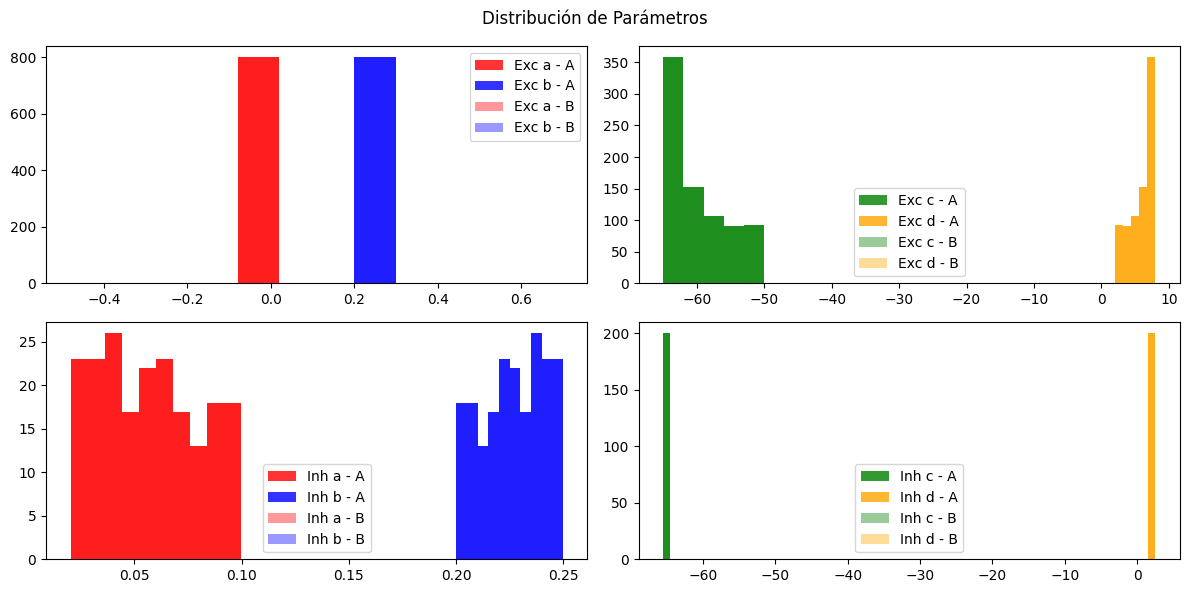

In [34]:
def plot_parameter_distributions(pop_A, pop_B, N_exc=800):
   """Graficar distribuciones de parámetros usando objetos de la red"""
   figure(figsize=(12, 6))
   suptitle('Distribución de Parámetros')

   # Extraer grupos
   group_A = pop_A
   group_B = pop_B
   
   # Separar parámetros exc/inh
   a_exc_A, a_inh_A = group_A.a[:N_exc], group_A.a[N_exc:]
   b_exc_A, b_inh_A = group_A.b[:N_exc], group_A.b[N_exc:]
   c_exc_A, c_inh_A = group_A.c[:N_exc], group_A.c[N_exc:]
   d_exc_A, d_inh_A = group_A.d[:N_exc], group_A.d[N_exc:]
   
   a_exc_B, a_inh_B = group_B.a[:N_exc], group_B.a[N_exc:]
   b_exc_B, b_inh_B = group_B.b[:N_exc], group_B.b[N_exc:]
   c_exc_B, c_inh_B = group_B.c[:N_exc], group_B.c[N_exc:]
   d_exc_B, d_inh_B = group_B.d[:N_exc], group_B.d[N_exc:]

   # Parámetros excitatorios a,b
   subplot(2, 2, 1)
   hist(a_exc_A, alpha=0.8, color='red', bins=10, label='Exc a - A')
   hist(b_exc_A, alpha=0.8, color='blue', bins=10, label='Exc b - A')
   hist(a_exc_B, alpha=0.4, color='red', bins=10, label='Exc a - B')
   hist(b_exc_B, alpha=0.4, color='blue', bins=10, label='Exc b - B')
   legend()

   # Parámetros excitatorios c,d
   subplot(2, 2, 2)
   hist(c_exc_A, alpha=0.8, color='green', bins=5, label='Exc c - A')
   hist(d_exc_A, alpha=0.8, color='orange', bins=5, label='Exc d - A')
   hist(c_exc_B, alpha=0.4, color='green', bins=5, label='Exc c - B')
   hist(d_exc_B, alpha=0.4, color='orange', bins=5, label='Exc d - B')
   legend()

   # Parámetros inhibitorios a,b
   subplot(2, 2, 3)
   hist(a_inh_A, alpha=0.8, color='red', bins=10, label='Inh a - A')
   hist(b_inh_A, alpha=0.8, color='blue', bins=10, label='Inh b - A')
   hist(a_inh_B, alpha=0.4, color='red', bins=10, label='Inh a - B')
   hist(b_inh_B, alpha=0.4, color='blue', bins=10, label='Inh b - B')
   legend()

   # Parámetros inhibitorios c,d
   subplot(2, 2, 4)
   hist(c_inh_A, alpha=0.8, color='green', bins=1, label='Inh c - A')
   hist(d_inh_A, alpha=0.8, color='orange', bins=1, label='Inh d - A')
   hist(c_inh_B, alpha=0.4, color='green', bins=1, label='Inh c - B')
   hist(d_inh_B, alpha=0.4, color='orange', bins=1, label='Inh d - B')
   legend()

   tight_layout()
   show()
   
plot_parameter_distributions(pop_A, pop_B)

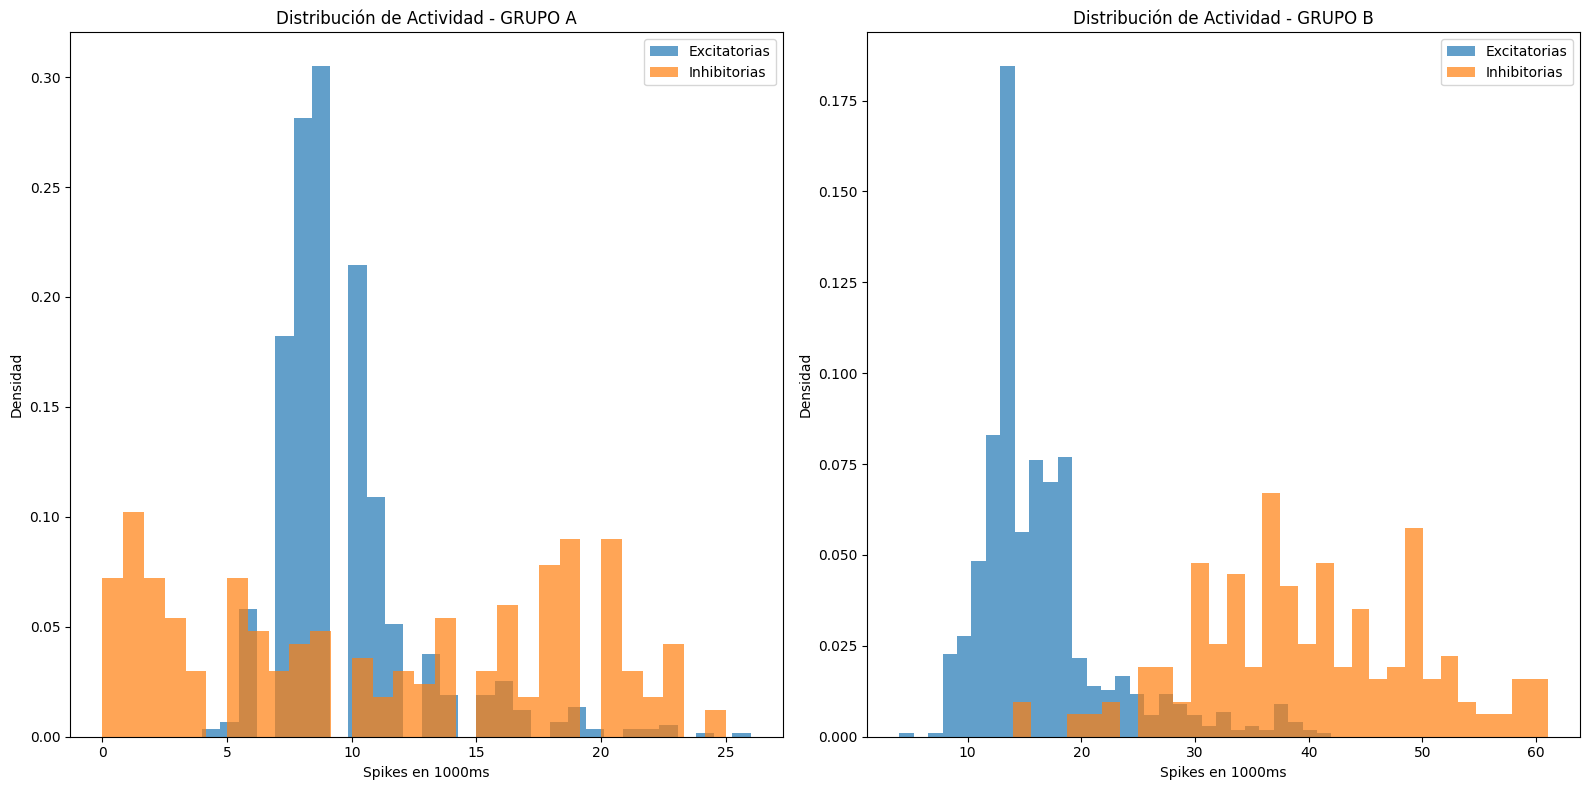

In [35]:
def plot_activity_distributions(results, N_exc=800, N_inh=200):
   """Graficar distribuciones de actividad usando resultados de la red"""
   figure(figsize=(16, 8))

   # Grupo A
   subplot(1, 2, 1)
   spike_mon_A = results['A']['spike_monitor']
   
   # Contar spikes por neurona
   freq_exc_A = [sum(spike_mon_A.i == i) for i in range(N_exc)]
   freq_inh_A = [sum(spike_mon_A.i == (i + N_exc)) for i in range(N_inh)]

   hist(freq_exc_A, bins=30, alpha=0.7, density=True, label='Excitatorias')
   hist(freq_inh_A, bins=30, alpha=0.7, density=True, label='Inhibitorias')
   xlabel('Spikes en 1000ms')
   ylabel('Densidad')
   title('Distribución de Actividad - GRUPO A')
   legend()

   # Grupo B
   subplot(1, 2, 2)
   spike_mon_B = results['B']['spike_monitor']
   
   freq_exc_B = [sum(spike_mon_B.i == i) for i in range(N_exc)]
   freq_inh_B = [sum(spike_mon_B.i == (i + N_exc)) for i in range(N_inh)]

   hist(freq_exc_B, bins=30, alpha=0.7, density=True, label='Excitatorias')
   hist(freq_inh_B, bins=30, alpha=0.7, density=True, label='Inhibitorias')
   xlabel('Spikes en 1000ms')
   ylabel('Densidad')
   title('Distribución de Actividad - GRUPO B')
   legend()

   tight_layout()
   show()
   
plot_activity_distributions(results)

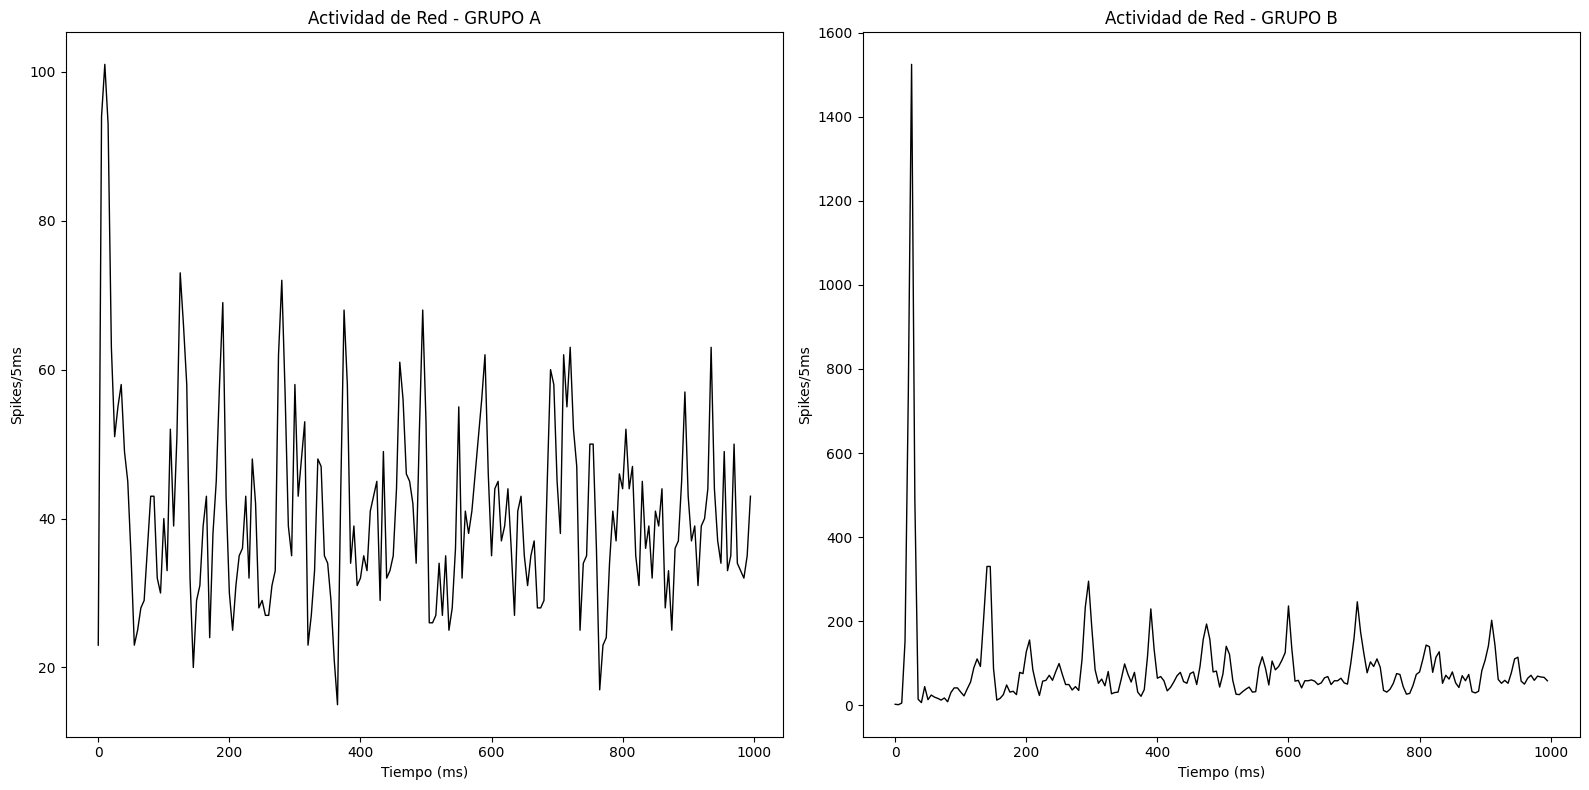

In [36]:
def plot_population_activity(results, bin_size_ms=5, T_total=1000):
   """Graficar actividad poblacional usando resultados de la red"""
   figure(figsize=(16, 8))

   time_bins = np.arange(0, T_total, bin_size_ms)

   # Grupo A
   subplot(1, 2, 1)
   spike_mon_A = results['A']['spike_monitor']
   spike_times_A = spike_mon_A.t/ms
   
   activity_A = []
   for t in time_bins:
       total_spikes = sum((spike_times_A >= t) & (spike_times_A < t + bin_size_ms))
       activity_A.append(total_spikes)

   plot(time_bins, activity_A, 'k-', linewidth=1)
   xlabel('Tiempo (ms)')
   ylabel(f'Spikes/{bin_size_ms}ms')
   title('Actividad de Red - GRUPO A')

   # Grupo B
   subplot(1, 2, 2)
   spike_mon_B = results['B']['spike_monitor']
   spike_times_B = spike_mon_B.t/ms
   
   activity_B = []
   for t in time_bins:
       total_spikes = sum((spike_times_B >= t) & (spike_times_B < t + bin_size_ms))
       activity_B.append(total_spikes)

   plot(time_bins, activity_B, 'k-', linewidth=1)
   xlabel('Tiempo (ms)')
   ylabel(f'Spikes/{bin_size_ms}ms')
   title('Actividad de Red - GRUPO B')

   tight_layout()
   show()
   
plot_population_activity(results)

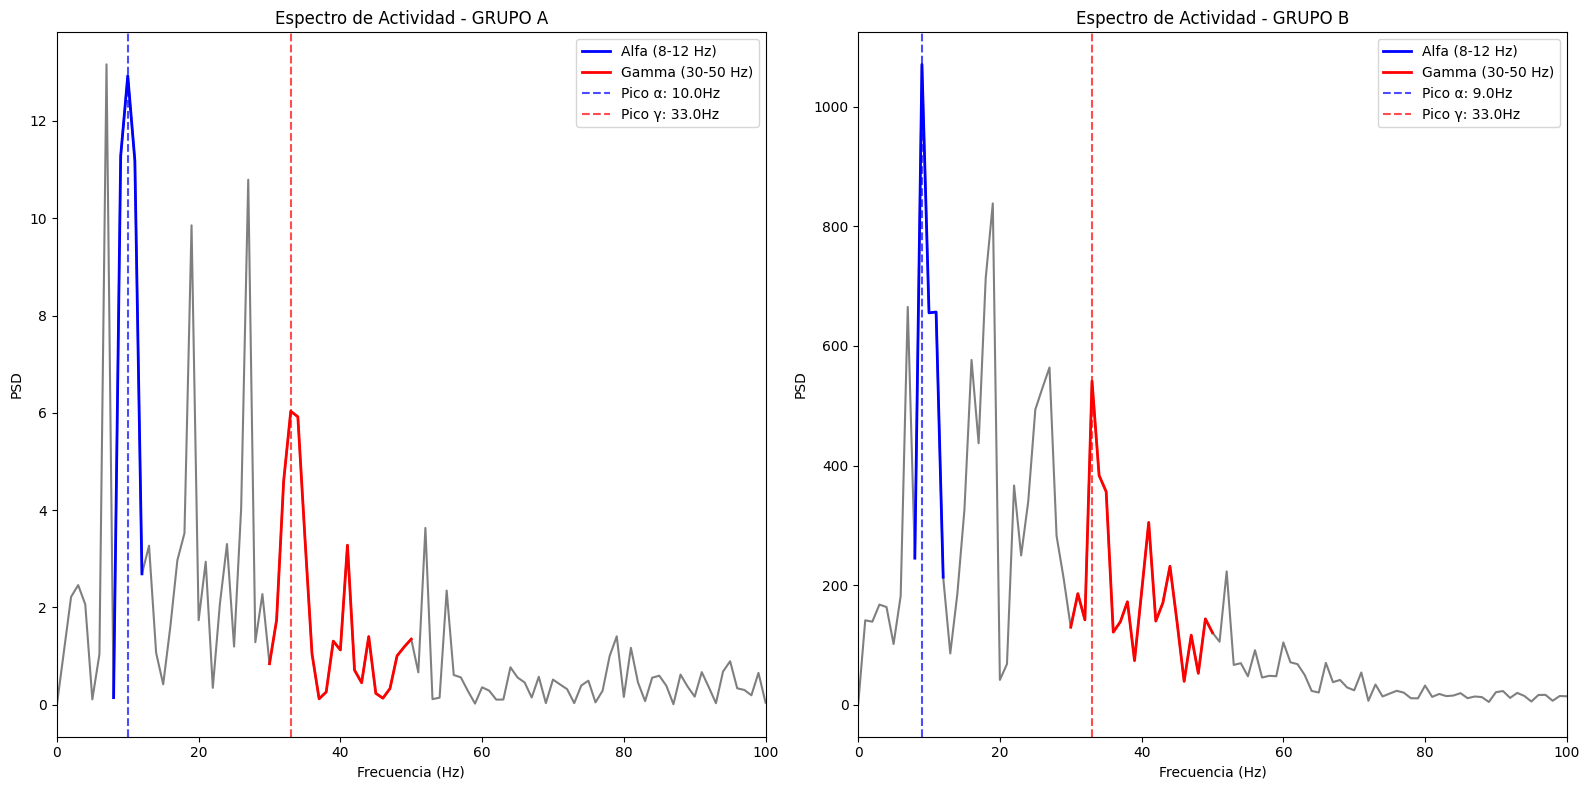

In [37]:
def plot_spectral_analysis(results, bin_size_ms=5, T_total=1000):
   """Análisis espectral de actividad poblacional"""
   from scipy import signal
   
   figure(figsize=(16, 8))
   time_bins = np.arange(0, T_total, bin_size_ms)
   
   # Calcular actividad para ambos grupos
   spike_mon_A = results['A']['spike_monitor']
   spike_times_A = spike_mon_A.t/ms
   activity_A = [sum((spike_times_A >= t) & (spike_times_A < t + bin_size_ms)) 
                 for t in time_bins]
   
   spike_mon_B = results['B']['spike_monitor']
   spike_times_B = spike_mon_B.t/ms
   activity_B = [sum((spike_times_B >= t) & (spike_times_B < t + bin_size_ms)) 
                 for t in time_bins]

   # Grupo A
   subplot(1, 2, 1)
   if len(activity_A) > 100:
       freqs, psd = signal.periodogram(activity_A, fs=1000/bin_size_ms)
       
       alpha_band = (freqs >= 8) & (freqs <= 12)
       gamma_band = (freqs >= 30) & (freqs <= 50)
       
       plot(freqs, psd, 'k-', alpha=0.5)
       plot(freqs[alpha_band], psd[alpha_band], 'b-', linewidth=2, label='Alfa (8-12 Hz)')
       plot(freqs[gamma_band], psd[gamma_band], 'r-', linewidth=2, label='Gamma (30-50 Hz)')
       
       if np.any(alpha_band) and np.any(gamma_band):
           alpha_peak = freqs[alpha_band][np.argmax(psd[alpha_band])]
           gamma_peak = freqs[gamma_band][np.argmax(psd[gamma_band])]
           axvline(alpha_peak, color='blue', linestyle='--', alpha=0.7, label=f'Pico α: {alpha_peak:.1f}Hz')
           axvline(gamma_peak, color='red', linestyle='--', alpha=0.7, label=f'Pico γ: {gamma_peak:.1f}Hz')
       
       xlabel('Frecuencia (Hz)')
       ylabel('PSD')
       title('Espectro de Actividad - GRUPO A')
       xlim(0, 100)
       legend()

   # Grupo B
   subplot(1, 2, 2)
   if len(activity_B) > 100:
       freqs, psd = signal.periodogram(activity_B, fs=1000/bin_size_ms)
       
       alpha_band = (freqs >= 8) & (freqs <= 12)
       gamma_band = (freqs >= 30) & (freqs <= 50)
       
       plot(freqs, psd, 'k-', alpha=0.5)
       plot(freqs[alpha_band], psd[alpha_band], 'b-', linewidth=2, label='Alfa (8-12 Hz)')
       plot(freqs[gamma_band], psd[gamma_band], 'r-', linewidth=2, label='Gamma (30-50 Hz)')
       
       if np.any(alpha_band) and np.any(gamma_band):
           alpha_peak = freqs[alpha_band][np.argmax(psd[alpha_band])]
           gamma_peak = freqs[gamma_band][np.argmax(psd[gamma_band])]
           axvline(alpha_peak, color='blue', linestyle='--', alpha=0.7, label=f'Pico α: {alpha_peak:.1f}Hz')
           axvline(gamma_peak, color='red', linestyle='--', alpha=0.7, label=f'Pico γ: {gamma_peak:.1f}Hz')
       
       xlabel('Frecuencia (Hz)')
       ylabel('PSD')
       title('Espectro de Actividad - GRUPO B')
       xlim(0, 100)
       legend()

   tight_layout()
   show()
   
plot_spectral_analysis(results)

In [38]:
def print_network_statistics(results, network, N_exc=800, N_inh=200, bin_size_ms=5, T_total=1000):
   """Imprimir estadísticas de red usando objetos de la clase"""
   
   # Calcular actividad poblacional
   def calculate_activity(spike_monitor):
       spike_times = spike_monitor.t/ms
       time_bins = np.arange(0, T_total, bin_size_ms)
       return [sum((spike_times >= t) & (spike_times < t + bin_size_ms)) for t in time_bins]
   
   def calculate_frequencies(spike_monitor, N_exc):
       freq_exc = [sum(spike_monitor.i == i) for i in range(N_exc)]
       freq_inh = [sum(spike_monitor.i == (i + N_exc)) for i in range(N_inh)]
       return freq_exc, freq_inh
   
   N_total = N_exc + N_inh
   
   for pop_name in ['A', 'B']:
       spike_mon = results[pop_name]['spike_monitor']
       group = network.populations[pop_name]['group']
       syn_intra = network.populations[pop_name]['syn_intra']
       
       activity = calculate_activity(spike_mon)
       freq_exc, freq_inh = calculate_frequencies(spike_mon, N_exc)
       
       print(f"\n{'='*60}")
       print(f"COMPARACIÓN CON PAPER ORIGINAL - GRUPO {pop_name}")
       print(f"{'='*60}")
       
       print(f"Arquitectura:")
       print(f"  Neuronas: {N_exc} exc + {N_inh} inh (ratio 4:1 ✓)")
       print(f"  Conexiones: {len(syn_intra.i)} totales")
       print(f"  Prob. conexión: {len(syn_intra.i)/(N_total**2):.3f} (paper: ~0.09)")
       
       print(f"\nActividad:")
       exc_spikes = sum(spike_mon.i < N_exc)
       inh_spikes = sum(spike_mon.i >= N_exc)
       mean_freq_exc = exc_spikes / N_exc
       mean_freq_inh = inh_spikes / N_inh
       
       print(f"  Freq. excitatorias: {mean_freq_exc:.1f} Hz (paper: ~8Hz)")
       print(f"  Freq. inhibitorias: {mean_freq_inh:.1f} Hz")
       print(f"  Spikes totales: {exc_spikes + inh_spikes}")
       
       print(f"\nParámetros (verificación aleatoria):")
       idx_exc = np.random.randint(0, N_exc)
       idx_inh = np.random.randint(N_exc, N_total)
       print(f"  Neurona exc #{idx_exc}: c={group.c[idx_exc]:.1f}, d={group.d[idx_exc]:.1f}")
       print(f"  Neurona inh #{idx_inh}: a={group.a[idx_inh]:.3f}, b={group.b[idx_inh]:.3f}")
       
       print(f"\nComportamiento emergente:")
       asynchrony = np.std(activity) / np.mean(activity) if np.mean(activity) > 0 else 0
       print(f"  Índice asincronía: {asynchrony:.2f} (>1 = asíncrono ✓)")
       active_exc = sum(np.array(freq_exc) > 0)
       print(f"  Neuronas activas: {active_exc}/{N_exc} ({100*active_exc/N_exc:.1f}%)")
       
print_network_statistics(results, sim)


COMPARACIÓN CON PAPER ORIGINAL - GRUPO A
Arquitectura:
  Neuronas: 800 exc + 200 inh (ratio 4:1 ✓)
  Conexiones: 99898 totales
  Prob. conexión: 0.100 (paper: ~0.09)

Actividad:
  Freq. excitatorias: 9.6 Hz (paper: ~8Hz)
  Freq. inhibitorias: 10.9 Hz
  Spikes totales: 9846

Parámetros (verificación aleatoria):
  Neurona exc #569: c=-63.2, d=7.3
  Neurona inh #869: a=0.096, b=0.203

Comportamiento emergente:
  Índice asincronía: 0.32 (>1 = asíncrono ✓)
  Neuronas activas: 800/800 (100.0%)

COMPARACIÓN CON PAPER ORIGINAL - GRUPO B
Arquitectura:
  Neuronas: 800 exc + 200 inh (ratio 4:1 ✓)
  Conexiones: 99898 totales
  Prob. conexión: 0.100 (paper: ~0.09)

Actividad:
  Freq. excitatorias: 16.4 Hz (paper: ~8Hz)
  Freq. inhibitorias: 39.8 Hz
  Spikes totales: 21075

Parámetros (verificación aleatoria):
  Neurona exc #423: c=-61.3, d=6.5
  Neurona inh #972: a=0.079, b=0.213

Comportamiento emergente:
  Índice asincronía: 1.45 (>1 = asíncrono ✓)
  Neuronas activas: 800/800 (100.0%)


In [39]:
def extract_currents_info(results, network, population_name, N_exc=800):
   """Extraer estadísticas de corrientes usando objetos de la clase"""
   
   # Obtener monitores (necesitas añadirlos al setup_monitors)
   group = network.populations[population_name]['group']
   
   # Separar datos por tipo neuronal
   def separate_by_type(data):
       return data[:, :N_exc], data[:, N_exc:]  # exc, inh
   
   # Calcular estadísticas
   def calc_stats(data):
       return {
           'mean_per_neuron': np.mean(data, axis=0),
           'std_per_neuron': np.std(data, axis=0),
           'mean_per_timestep': np.mean(data, axis=1),
           'min_per_timestep': np.min(data, axis=1),
           'max_per_timestep': np.max(data, axis=1)
       }
   
   # Datos de corrientes (necesitas monitorearlos primero)
   I_thal = results[population_name]['I_thalamic']  # Añadir a get_results()
   I_syn = results[population_name]['I_syn']
   
   I_thal_exc, I_thal_inh = separate_by_type(I_thal)
   I_syn_exc, I_syn_inh = separate_by_type(I_syn)
   
   I_tot_exc = I_thal_exc + I_syn_exc
   I_tot_inh = I_thal_inh + I_syn_inh
   
   stats = {
       'thalamic_exc': calc_stats(I_thal_exc),
       'synaptic_exc': calc_stats(I_syn_exc),
       'total_exc': calc_stats(I_tot_exc),
       'thalamic_inh': calc_stats(I_thal_inh),
       'synaptic_inh': calc_stats(I_syn_inh),
       'total_inh': calc_stats(I_tot_inh)
   }
   
   print(f"=== Estadísticas del Grupo {population_name} ===")
   print("=== INPUT TALÁMICO ===")
   print(f"Brian2 exc - Media por neurona: {np.mean(stats['thalamic_exc']['mean_per_neuron']):.4f}")
   print(f"Brian2 exc - Std por neurona: {np.mean(stats['thalamic_exc']['std_per_neuron']):.4f}")
   
   print("\n=== INPUT SINÁPTICO ===")
   print(f"Brian2 exc - Media: {np.mean(stats['synaptic_exc']['mean_per_neuron']):.4f}")
   print(f"Brian2 exc - Std: {np.mean(stats['synaptic_exc']['std_per_neuron']):.4f}")
   print(f"Brian2 exc - Rango típico: [{np.mean(stats['synaptic_exc']['min_per_timestep']):.2f}, {np.mean(stats['synaptic_exc']['max_per_timestep']):.2f}]")
   
   return stats


stats_A = extract_currents_info(results, sim, 'A')
stats_B = extract_currents_info(results, sim, 'B')

KeyError: 'I_thalamic'

== Estadísticas del Grupo A ===

=== INPUT TALÁMICO ===
Brian2 exc - Media por neurona: -0.0019
Brian2 exc - Std por neurona: 4.9974

=== INPUT SINÁPTICO ===
Brian2 exc - Media: 0.8016
Brian2 exc - Std: 0.5017
Brian2 exc - Rango típico: [-4.84, 9.81]

=== Estadísticas del Grupo B ===

=== INPUT TALÁMICO ===
Brian2 exc - Media por neurona: -0.0039
Brian2 exc - Std por neurona: 5.0036

=== INPUT SINÁPTICO ===
Brian2 exc - Media: 0.8246
Brian2 exc - Std: 0.5066
Brian2 exc - Rango típico: [-4.62, 6.72]

In [ ]:
# Función para analizar resultados
def plot_two_population_results(results):
    """Graficar raster plots de ambas poblaciones"""
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Población A
    axes[0].plot(results['A']['spike_times'], results['A']['spike_indices'], 
                '.', markersize=0.5, color='black', alpha=0.7)
    axes[0].set_ylabel('Neurona A')
    axes[0].set_title(f'Red de Dos Poblaciones - dt = {results["dt"]} ms')
    axes[0].axhline(y=800, color='red', linestyle='--')
    
    # Población B
    axes[1].plot(results['B']['spike_times'], results['B']['spike_indices'], 
                '.', markersize=0.5, color='black')
    axes[1].set_ylabel('Neurona B')
    axes[1].set_xlabel('Tiempo (ms)')
    axes[1].axhline(y=800, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas
    print(f"Spikes A: {len(results['A']['spike_times'])}")
    print(f"Spikes B: {len(results['B']['spike_times'])}")
    print(f"Rate A: {len(results['A']['spike_times'])/(results['T_total']*800)*1000:.2f} Hz")
    print(f"Rate B: {len(results['B']['spike_times'])/(results['T_total']*800)*1000:.2f} Hz")

=== EXPERIMENTO 1: Poblaciones Aisladas ===

=== Análisis de Conectividad - Isolated ===
Cross-correlation peak: 0.496 at 2.5ms
PLV Alpha: 0.528
PLI Alpha: 0.528
PLV Gamma: 0.429
PLI Gamma: 0.345
Coherence peak: 0.572 at 44.5Hz
Intrinsic timescales: Pop A = 7.0ms (poor), Pop B = 7.1ms (poor)
=== EXPERIMENTO 2: Acoplamiento Simétrico ===

=== Análisis de Conectividad - Symmetric ===
Cross-correlation peak: 0.983 at -8.9ms
PLV Alpha: 0.949
PLI Alpha: 0.927
PLV Gamma: 0.851
PLI Gamma: 0.851
Coherence peak: 0.950 at 4.5Hz
Intrinsic timescales: Pop A = 6.4ms (poor), Pop B = 6.9ms (poor)
=== EXPERIMENTO 3: Sin Delay (Control) ===

=== Análisis de Conectividad - No_Delay ===
Cross-correlation peak: 0.768 at 5.9ms
PLV Alpha: 0.531
PLI Alpha: 0.531
PLV Gamma: 0.523
PLI Gamma: 0.507
Coherence peak: 0.653 at 32.0Hz
Intrinsic timescales: Pop A = 6.8ms (poor), Pop B = 6.7ms (poor)


WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/metrics.py:545: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]


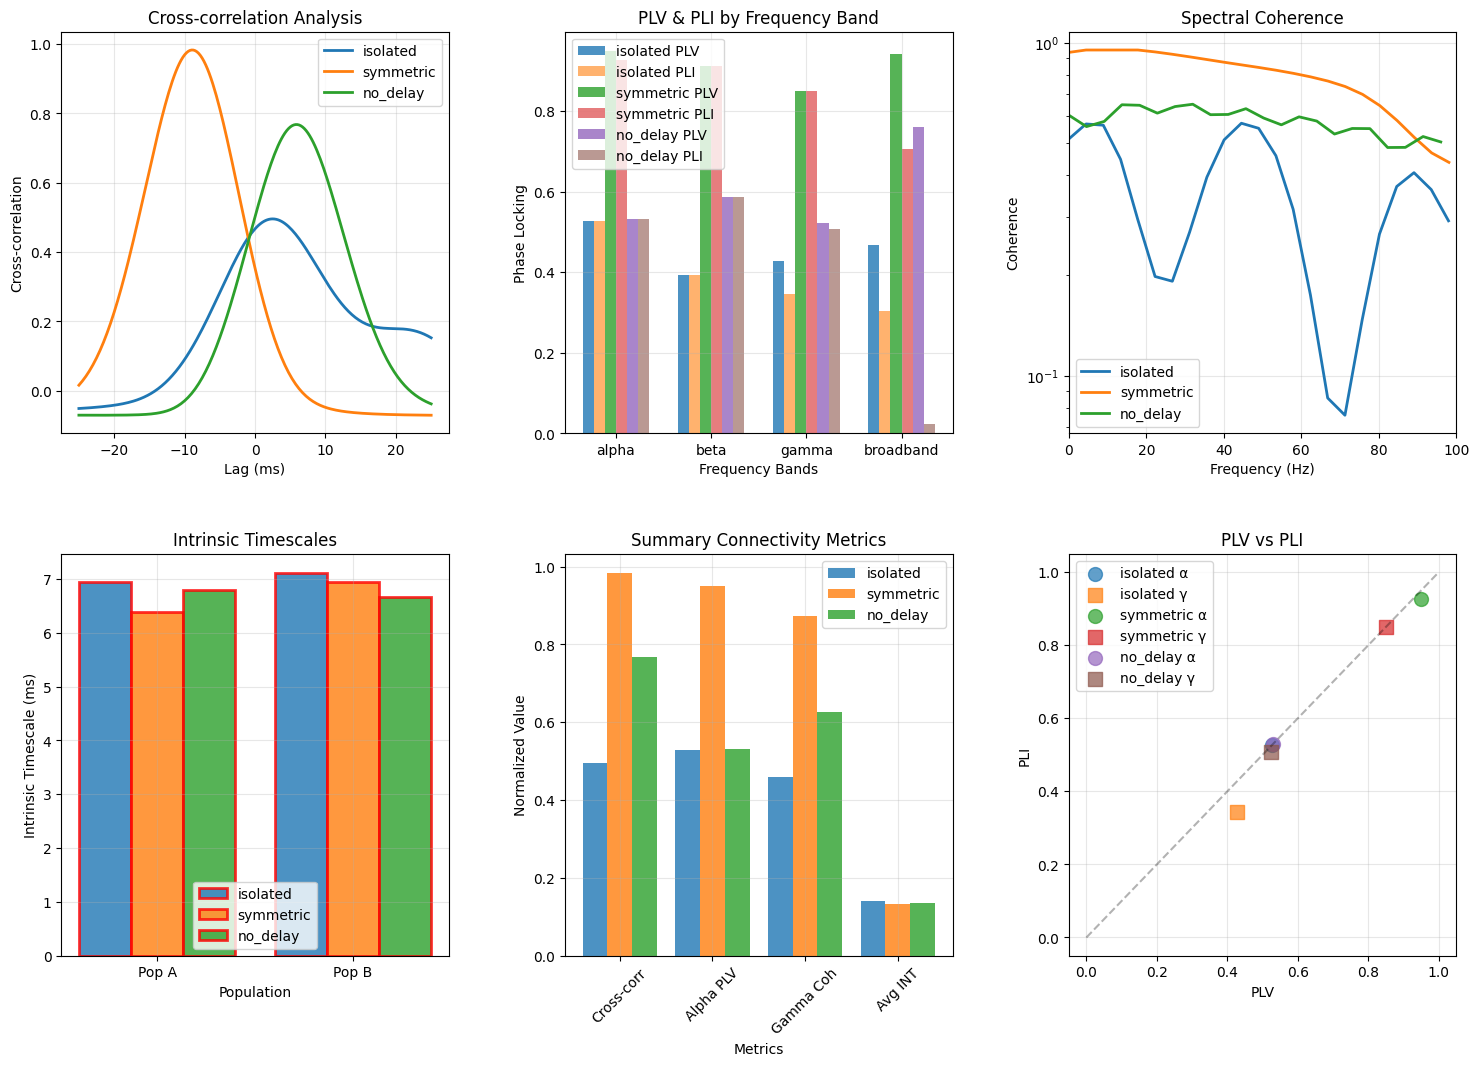

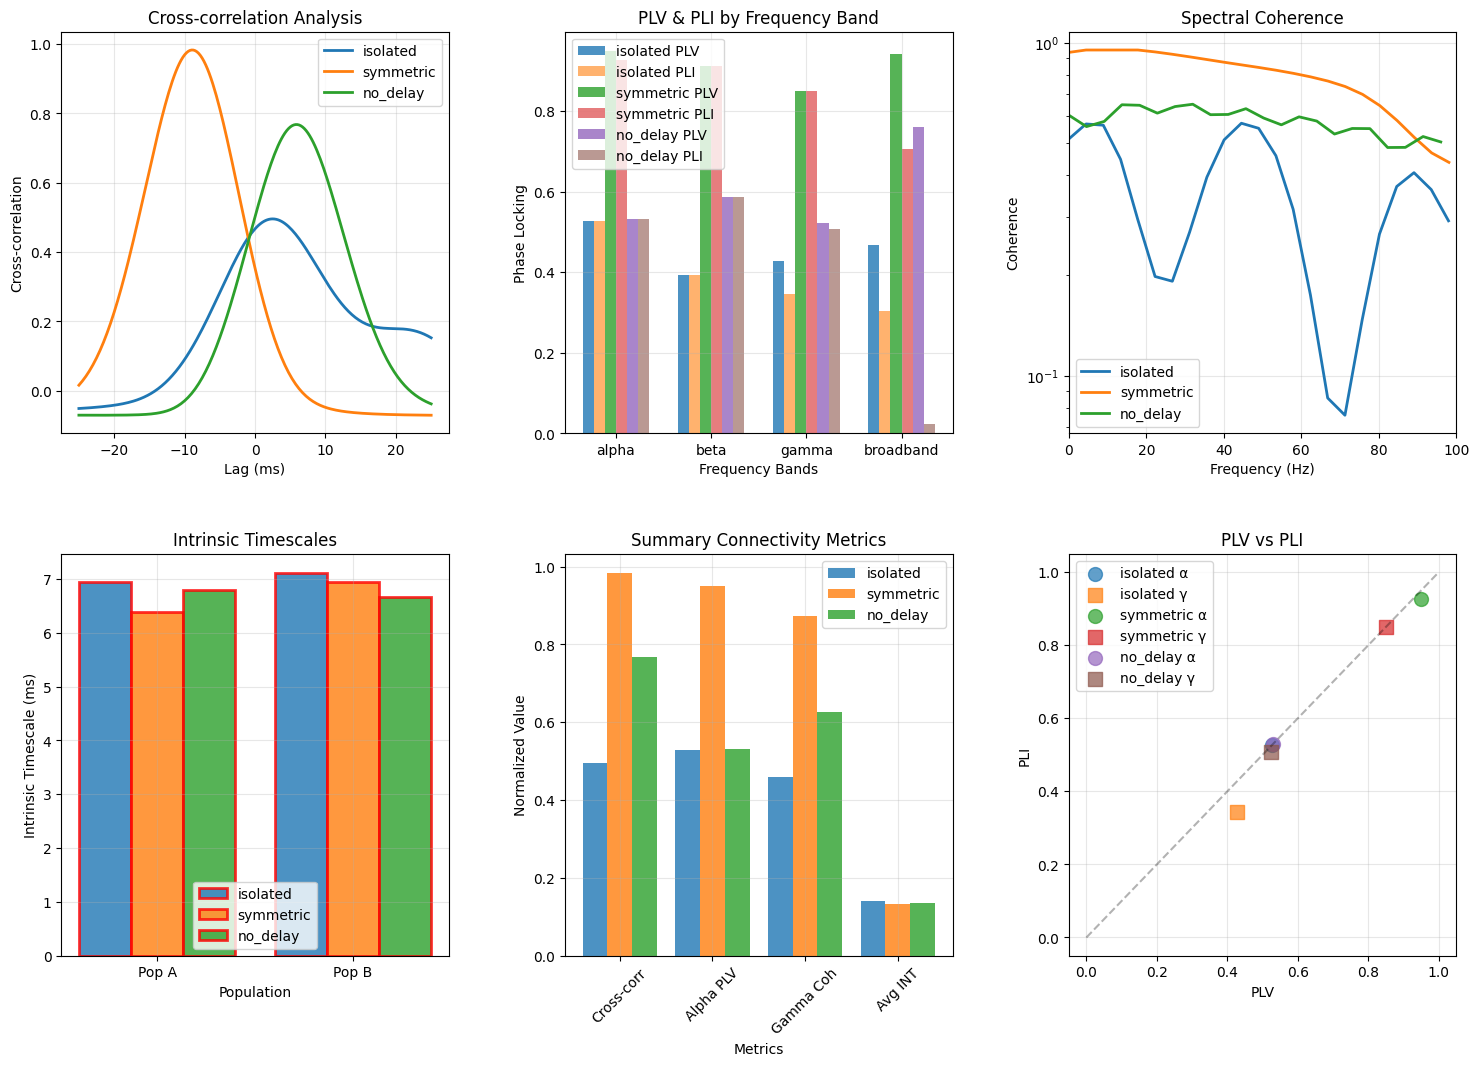

In [ ]:
from src.two_populations.metrics import plot_connectivity_dashboard, analyze_simulation_results, plot_population_dashboard


def run_validation_experiments(simulator_class):
    """
    Suite de experimentos de validación para verificar comportamiento base
    """
    validation_results = {}
    
    k_factor = 5
    noise_int = 5.1 # 5.1 

    inter_k_factor = 0.1
    noise_inh_factor = 0.451
        
    # 1. POBLACIONES AISLADAS (sin conexión inter-poblacional)
    print("=== EXPERIMENTO 1: Poblaciones Aisladas ===")
    sim_isolated = simulator_class(dt_val=0.01, T_total=2000, seed_val=42)
    
    # Población con ruido constante
    pop_A = sim_isolated.create_population('A', Ne=800, Ni=200, k_exc=k_factor*0.5, k_inh=k_factor*1.0,
                                noise_exc=noise_int, noise_inh=round(noise_int * noise_inh_factor, 2), p_intra=0.1, delay = 0.2,  noise_type='poisson')
    pop_B = sim_isolated.create_population('B', Ne=800, Ni=200, k_exc=k_factor*0.5, k_inh=k_factor*1.0,
                                noise_exc=noise_int, noise_inh=round(noise_int * noise_inh_factor/2, 2), p_intra=0.1, delay = 0.2, noise_type='poisson') 
    
    # NO conectar poblaciones
    
    sim_isolated.setup_monitors(['A', 'B'])
    results_isolated = sim_isolated.run_simulation()
    
    # Verificar: cada población debe mostrar actividad independiente
    validation_results['isolated'] = analyze_simulation_results(
        results_isolated['A']['spike_monitor'], 
        results_isolated['B']['spike_monitor'], 
        1000, "Isolated"
    )
    
    # 2. ACOPLAMIENTO SIMÉTRICO (bidireccional igual)
    print("=== EXPERIMENTO 2: Acoplamiento Simétrico ===")
    sim_symmetric = simulator_class(dt_val=0.01, T_total=2000, seed_val=43)
    
    pop_A = sim_symmetric.create_population('A', Ne=800, Ni=200, k_exc=k_factor*0.5, k_inh=k_factor*1.0,
                                noise_exc=noise_int, noise_inh=round(noise_int * noise_inh_factor, 2), p_intra=0.1, delay = 0.2,  noise_type='poisson')
    pop_B = sim_symmetric.create_population('B', Ne=800, Ni=200, k_exc=k_factor*0.5, k_inh=k_factor*1.0,
                                noise_exc=noise_int, noise_inh=round(noise_int * noise_inh_factor/2, 2), p_intra=0.1, delay = 0.2, noise_type='poisson') 
    
    # Conexiones simétricas con mismo delay
    sim_symmetric.connect_populations('A', 'B', p_inter=0.01, weight_scale=k_factor*inter_k_factor, delay_value=5.0)
    sim_symmetric.connect_populations('B', 'A', p_inter=0.01, weight_scale=k_factor*inter_k_factor, delay_value=5.0)
    
    sim_symmetric.setup_monitors(['A', 'B'])
    results_symmetric = sim_symmetric.run_simulation()
    
    validation_results['symmetric'] = analyze_simulation_results(
        results_symmetric['A']['spike_monitor'], 
        results_symmetric['B']['spike_monitor'], 
        1000, "Symmetric"
    )
    
    # 3. CONTROL: SIN DELAY (delay mínimo)
    print("=== EXPERIMENTO 3: Sin Delay (Control) ===")
    sim_nodelay = simulator_class(dt_val=0.01, T_total=2000, seed_val=44)
    
    pop_A = sim_nodelay.create_population('A', Ne=800, Ni=200, k_exc=k_factor*0.5, k_inh=k_factor*1.0,
                                noise_exc=noise_int, noise_inh=round(noise_int * noise_inh_factor, 2), p_intra=0.1, delay = 0.2,  noise_type='poisson')
    pop_B = sim_nodelay.create_population('B', Ne=800, Ni=200, k_exc=k_factor*0.5, k_inh=k_factor*1.0,
                                noise_exc=noise_int, noise_inh=round(noise_int * noise_inh_factor/2, 2), p_intra=0.1, delay = 0.2, noise_type='poisson') 
    
    sim_nodelay.connect_populations('A', 'B', p_inter=0.02, weight_scale=k_factor*inter_k_factor, delay_value=0.5)
    
    sim_nodelay.setup_monitors(['A', 'B'])
    results_nodelay = sim_nodelay.run_simulation()
    
    validation_results['no_delay'] = analyze_simulation_results(
        results_nodelay['A']['spike_monitor'], 
        results_nodelay['B']['spike_monitor'], 
        1000, "No_Delay"
    )
    
    return validation_results

# Ejecutar validación
validation_results = run_validation_experiments(IzhikevichNetwork)
plot_connectivity_dashboard(validation_results)

# CRITERIOS DE VALIDACIÓN:
# 1. Poblaciones aisladas: PLV < 0.2, cross-correlation peak < 0.3
# 2. Acoplamiento simétrico: PLV moderado (0.3-0.6), cross-correlation simétrico
# 3. Sin delay: PLV alto (>0.5), cross-correlation peak cerca de lag=0